<a href="https://colab.research.google.com/github/rishi15-t/PP-MM/blob/master/PP_MM_BaseModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
dataset = pd.read_pickle('/content/drive/My Drive/dataset/w2v_vgg_embeddings.pkl')

In [0]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import torch
from torch.nn import BCEWithLogitsLoss
from torch.nn.functional import softplus
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn.utils import clip_grad_norm_
from torch.optim import AdamW
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm, trange
from sklearn import metrics
#!pip install transformers
#from transformers import get_linear_schedule_with_warmup
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
import pandas as pd
import numpy as np
import time
import datetime
#!pip install git+https://github.com/uber/pyro.git
import pyro
from pyro import poutine
from pyro.distributions import Normal, Categorical, Laplace
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO
from pyro.optim import ClippedAdam


def Train_Test_Val_Split(data , test_data_fraction = 0.3, val_data_fraction = 0.1) :
    
  
    data_genres_one_hot_encoding = pd.DataFrame.from_items(zip(data['genres'].index, data['genres'].values)).T
    Label_names = np.array(['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir',
       'History', 'Horror', 'Music', 'Musical', 'Mystery', 'Romance',
       'Sci-Fi', 'Short', 'Sport', 'Thriller', 'War', 'Western'])
    data_genres_one_hot_encoding.columns = Label_names
    Data_train, Data_test, Labels_train, Labels_test = train_test_split(data, data_genres_one_hot_encoding, test_size = test_data_fraction)

    Data_train, Data_val, Labels_train, Labels_val = train_test_split(Data_train, Labels_train, test_size = val_data_fraction)

    Data_train = Data_train.reset_index(drop=True)
    Data_test = Data_test.reset_index(drop=True)
    Data_val = Data_val.reset_index(drop=True)
    
    Labels_train = torch.tensor(Labels_train.values)
    Labels_test = torch.tensor(Labels_test.values)
    Labels_val = torch.tensor(Labels_val.values)
    
    return (Data_train, Data_test, Data_val, Labels_train, Labels_test, Labels_val, Label_names)
    
Data_train, Data_test, Data_val, Labels_train_tensor, Labels_test_tensor, Labels_val_tensor, Label_names = Train_Test_Val_Split(dataset)

Data_train_tensor_text = torch.tensor(Data_train['w2v_embeddings'])
Data_test_tensor_text = torch.tensor(Data_test['w2v_embeddings'])
Data_val_tensor_text = torch.tensor(Data_val['w2v_embeddings'])

Data_train_tensor_image = torch.tensor(Data_train['vgg16_embeddings'])
Data_test_tensor_image = torch.tensor(Data_test['vgg16_embeddings'])
Data_val_tensor_image = torch.tensor(Data_val['vgg16_embeddings'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  # Remove the CWD from sys.path while we load stuff.


In [0]:
#Neural networks


#source: https://github.com/Duncanswilson/maxout-pytorch/blob/master/maxout_pytorch.ipynb
class ListModule(object):
    def __init__(self, module, prefix, *args):
        self.module = module
        self.prefix = prefix
        self.num_module = 0
        for new_module in args:
            self.append(new_module)

    def append(self, new_module):
        if not isinstance(new_module, nn.Module):
            raise ValueError('Not a Module')
        else:
            self.module.add_module(self.prefix + str(self.num_module), new_module)
            self.num_module += 1

    def __len__(self):
        return self.num_module

    def __getitem__(self, i):
        if i < 0 or i >= self.num_module:
            raise IndexError('Out of bound')
        return getattr(self.module, self.prefix + str(i))


class Maxout_MLP(nn.Module):
    
    def __init__(self, hidden_layer_size1, hidden_layer_size2, dropout, num_labels = 23, num_maxout_units=2):
        
        super(Maxout_MLP, self).__init__()
        self.fc1_list = ListModule(self, "fc1_")
        self.fc2_list = ListModule(self, "fc2_")
        self.hidden_layer_size1 = hidden_layer_size1
        self.hidden_layer_size2 = hidden_layer_size2
        for _ in range(num_maxout_units):
            self.fc1_list.append(nn.Linear(self.hidden_layer_size1, self.hidden_layer_size2))
            self.fc2_list.append(nn.Linear(self.hidden_layer_size2, self.hidden_layer_size2))
        self.dropout = nn.Dropout(p=dropout)
        self.sigmoid = torch.nn.Sigmoid()
        self.linear = torch.nn.Linear(self.hidden_layer_size2, num_labels)  #PP_MM_pattern 4

        self.bn0 = nn.BatchNorm1d(self.hidden_layer_size1)
        self.bn1 = nn.BatchNorm1d(self.hidden_layer_size2)
        self.bn2 = nn.BatchNorm1d(self.hidden_layer_size2)

    def forward(self, x): 
        
        x = x.view(-1, self.hidden_layer_size1)
        x = self.bn0(x)
        x = self.maxout(x, self.fc1_list)
        x = self.bn1(x)
        x = self.dropout(x)
        x = self.maxout(x, self.fc2_list)
        x = self.bn2(x)
        '''
        PP_MM_pattern 4
        '''
        logits = self.linear(x)  
        if(self.training) :     
            return logits
        else :
            output = self.sigmoid(logits)
            return output

    def maxout(self, x, layer_list):
        
        max_output = layer_list[0](x)
        for _, layer in enumerate(layer_list, start=1):
            max_output = torch.max(max_output, layer(x))
        return max_output


class GMU(nn.Module):

    def __init__(self, num_maxout_units = 2, hidden_layer_size = 512, text_embeddings_size = 300, img_embeddings_size = 4096, num_labels = 23, hidden_activation = None, dropout = 0.1):

        super(GMU, self).__init__()
        self.num_labels = num_labels
        self.hidden_layer_size = hidden_layer_size

        self.linear_h_text = torch.nn.Linear(text_embeddings_size, self.hidden_layer_size)
        self.linear_h_image = torch.nn.Linear(img_embeddings_size, self.hidden_layer_size)
        self.linear_z = torch.nn.Linear(text_embeddings_size + img_embeddings_size, self.hidden_layer_size)

        self.mm0 = nn.Linear(self.hidden_layer_size, self.hidden_layer_size) #PP_MM_pattern 4
        self.mm1 = nn.Linear(self.hidden_layer_size, self.hidden_layer_size) #PP_MM_pattern 4

        
        self.tanh = torch.nn.Tanh()
        self.sigmoid = torch.nn.Sigmoid()
        self.dropout = nn.Dropout(p=dropout)

        self.bn0 = nn.BatchNorm1d(img_embeddings_size)
        self.bn1 = nn.BatchNorm1d(text_embeddings_size)
        self.bn2 = nn.BatchNorm1d(text_embeddings_size + img_embeddings_size)

    def forward(self, text_embeddings, image_embeddings):
        
        image_embeddings = self.bn0(image_embeddings)
        image_h = self.linear_h_image(image_embeddings)
        image_h = self.tanh(image_h)

        text_embeddings = self.bn1(text_embeddings)
        text_h = self.linear_h_text(text_embeddings)
        text_h = self.tanh(text_h)

        concat = torch.cat((image_embeddings, text_embeddings), 1)
        concat = self.bn2(concat)
        z = self.linear_z(concat)
        z = self.sigmoid(z)
        gmu_output = z*image_h + (1-z)*text_h
        
        gmu_output = self.mm0(gmu_output)  #PP_MM_pattern 4
        gmu_output = self.tanh(gmu_output)  #PP_MM_pattern 4
        gmu_output = self.mm1(gmu_output)  #PP_MM_pattern 4
        attendout = self.tanh(gmu_output)  #PP_MM_pattern 4

        return attendout  #PP_MM_pattern 4   


 

In [0]:
# Pyro module defined only over the GMU NN

class GMU_Pyro():

    def __init__(self, model):

        self.model = model 
    
    def gmu_model(self, text_embeddings, image_embeddings, labels):

        #pyro.module("self.model", self)
        #global x_label

        linear_h_text_prior_w = Laplace(loc=torch.ones_like(self.model.linear_h_text.weight), scale=torch.ones_like(self.model.linear_h_text.weight))
        linear_h_text_prior_b = Laplace(loc=torch.ones_like(self.model.linear_h_text.bias), scale=torch.ones_like(self.model.linear_h_text.bias))
        linear_h_image_prior_w = Laplace(loc=torch.ones_like(self.model.linear_h_image.weight), scale=torch.ones_like(self.model.linear_h_image.weight))
        linear_h_image_prior_b = Laplace(loc=torch.ones_like(self.model.linear_h_image.bias), scale=torch.ones_like(self.model.linear_h_image.bias))
        linear_z_prior_w = Laplace(loc=torch.ones_like(self.model.linear_z.weight), scale=torch.ones_like(self.model.linear_z.weight))
        linear_z_prior_b = Laplace(loc=torch.ones_like(self.model.linear_z.bias), scale=torch.ones_like(self.model.linear_z.bias))

        mm0_prior_w = Laplace(loc=torch.ones_like(self.model.mm0.weight), scale=torch.ones_like(self.model.mm0.weight))
        mm0_prior_b = Laplace(loc=torch.ones_like(self.model.mm0.bias), scale=torch.ones_like(self.model.mm0.bias))
        mm1_prior_w = Laplace(loc=torch.ones_like(self.model.mm1.weight), scale=torch.ones_like(self.model.mm1.weight))
        mm1_prior_b = Laplace(loc=torch.ones_like(self.model.mm1.bias), scale=torch.ones_like(self.model.mm1.bias))

        priors = {
            'linear_h_text.weight': linear_h_text_prior_w, 'linear_h_text.bias': linear_h_text_prior_b,
            'linear_h_image.weight': linear_h_image_prior_w, 'linear_h_image.bias': linear_h_image_prior_b,
            'linear_z.weight': linear_z_prior_w, 'linear_z.bias': linear_z_prior_b,
            'mm0.weight': mm0_prior_w, 'mm0.bias': mm0_prior_b,
            'mm1.weight': mm1_prior_w, 'mm1.bias': mm1_prior_b}

        lifted_module = pyro.random_module("module", self.model, priors)
        lifted_reg_model = lifted_module()

        lhat = torch.sigmoid(lifted_reg_model(text_embeddings, image_embeddings))
        pyro.sample("obs", Categorical(logits=lhat), obs=labels)

    
    def gmu_guide(self, text_embeddings, image_embeddings, labels):

        #pyro.module("self.model", self)

        # linear_h_text
        # weight
        lwlinear_h_text = torch.empty_like(self.model.linear_h_text.weight)
        swlinear_h_text = torch.empty_like(self.model.linear_h_text.weight)
        torch.nn.init.normal_(lwlinear_h_text, std=0.01)
        torch.nn.init.normal_(swlinear_h_text, std=0.1)
        linear_h_text_loc_param_w_l = pyro.param("linear_h_text_loc_w_l", lwlinear_h_text)
        linear_h_text_loc_param_w_s = softplus(pyro.param("linear_h_text_loc_w_s", swlinear_h_text))
        linear_h_text_prior_w = Laplace(loc=linear_h_text_loc_param_w_l, scale=linear_h_text_loc_param_w_s)
        # bias
        lblinear_h_text = torch.empty_like(self.model.linear_h_text.bias)
        sblinear_h_text = torch.empty_like(self.model.linear_h_text.bias)
        torch.nn.init.normal_(lblinear_h_text, std=0.01)
        torch.nn.init.normal_(sblinear_h_text, std=0.1)
        linear_h_text_loc_param_b_l = pyro.param("linear_h_text_loc_b_l", lblinear_h_text)
        linear_h_text_loc_param_b_s = softplus(pyro.param("linear_h_text_loc_b_s", sblinear_h_text))
        linear_h_text_prior_b = Laplace(loc=linear_h_text_loc_param_b_l, scale=linear_h_text_loc_param_b_s)

        # linear_h_image
        # weight
        lwlinear_h_image = torch.empty_like(self.model.linear_h_image.weight)
        swlinear_h_image = torch.empty_like(self.model.linear_h_image.weight)
        torch.nn.init.normal_(lwlinear_h_image, std=0.01)
        torch.nn.init.normal_(swlinear_h_image, std=0.1)
        linear_h_image_loc_param_w_l = pyro.param("linear_h_image_loc_w_l", lwlinear_h_image)
        linear_h_image_loc_param_w_s = softplus(pyro.param("linear_h_image_loc_w_s", swlinear_h_image))
        linear_h_image_prior_w = Laplace(loc=linear_h_image_loc_param_w_l, scale=linear_h_image_loc_param_w_s)
        # bias
        lblinear_h_image = torch.empty_like(self.model.linear_h_image.bias)
        sblinear_h_image = torch.empty_like(self.model.linear_h_image.bias)
        torch.nn.init.normal_(lblinear_h_image, std=0.01)
        torch.nn.init.normal_(sblinear_h_image, std=0.1)
        linear_h_image_loc_param_b_l = pyro.param("linear_h_image_loc_b_l", lblinear_h_image)
        linear_h_image_loc_param_b_s = softplus(pyro.param("linear_h_image_loc_b_s", sblinear_h_image))
        linear_h_image_prior_b = Laplace(loc=linear_h_image_loc_param_b_l, scale=linear_h_image_loc_param_b_s)

        # linear_z
        # weight
        lwlinear_z = torch.empty_like(self.model.linear_z.weight)
        swlinear_z = torch.empty_like(self.model.linear_z.weight)
        torch.nn.init.normal_(lwlinear_z, std=0.01)
        torch.nn.init.normal_(swlinear_z, std=0.1)
        linear_z_loc_param_w_l = pyro.param("linear_z_loc_w_l", lwlinear_z)
        linear_z_loc_param_w_s = softplus(pyro.param("linear_z_loc_w_s", swlinear_z))
        linear_z_prior_w = Laplace(loc=linear_z_loc_param_w_l, scale=linear_z_loc_param_w_s)
        # bias
        lblinear_z = torch.empty_like(self.model.linear_z.bias)
        sblinear_z = torch.empty_like(self.model.linear_z.bias)
        torch.nn.init.normal_(lblinear_z, std=0.01)
        torch.nn.init.normal_(sblinear_z, std=0.1)
        linear_z_loc_param_b_l = pyro.param("linear_z_loc_b_l", lblinear_z)
        linear_z_loc_param_b_s = softplus(pyro.param("linear_z_loc_b_s", sblinear_z))
        linear_z_prior_b = Laplace(loc=linear_z_loc_param_b_l, scale=linear_z_loc_param_b_s)

        # mm0
        # weight
        lwmm0 = torch.empty_like(self.model.mm0.weight)
        swmm0 = torch.empty_like(self.model.mm0.weight)
        torch.nn.init.normal_(lwmm0, std=0.01)
        torch.nn.init.normal_(swmm0, std=0.1)
        mm0_loc_param_w_l = pyro.param("mm0_loc_w_l", lwmm0)
        mm0_loc_param_w_s = softplus(pyro.param("mm0_loc_w_s", swmm0))
        mm0_prior_w = Laplace(loc=mm0_loc_param_w_l, scale=mm0_loc_param_w_s)
        # bias
        lbmm0 = torch.empty_like(self.model.mm0.bias)
        sbmm0 = torch.empty_like(self.model.mm0.bias)
        torch.nn.init.normal_(lbmm0, std=0.01)
        torch.nn.init.normal_(sbmm0, std=0.1)
        mm0_loc_param_b_l = pyro.param("mm0_loc_b_l", lbmm0)
        mm0_loc_param_b_s = softplus(pyro.param("mm0_loc_b_s", sbmm0))
        mm0_prior_b = Laplace(loc=mm0_loc_param_b_l, scale=mm0_loc_param_b_s)

        # mm1
        # weight
        lwmm1 = torch.empty_like(self.model.mm1.weight)
        swmm1 = torch.empty_like(self.model.mm1.weight)
        torch.nn.init.normal_(lwmm1, std=0.01)
        torch.nn.init.normal_(swmm1, std=0.1)
        mm1_loc_param_w_l = pyro.param("mm1_loc_w_l", lwmm1)
        mm1_loc_param_w_s = softplus(pyro.param("mm1_loc_w_s", swmm1))
        mm1_prior_w = Laplace(loc=mm1_loc_param_w_l, scale=mm1_loc_param_w_s)
        # bias
        lbmm1 = torch.empty_like(self.model.mm1.bias)
        sbmm1 = torch.empty_like(self.model.mm1.bias)
        torch.nn.init.normal_(lbmm1, std=0.01)
        torch.nn.init.normal_(sbmm1, std=0.1)
        mm1_loc_param_b_l = pyro.param("mm1_loc_b_l", lbmm1)
        mm1_loc_param_b_s = softplus(pyro.param("mm1_loc_b_s", sbmm1))
        mm1_prior_b = Laplace(loc=mm1_loc_param_b_l, scale=mm1_loc_param_b_s)

        priors = {
        'linear_h_text.weight': linear_h_text_prior_w, 'linear_h_text.bias': linear_h_text_prior_b,
        'linear_h_image.weight': linear_h_image_prior_w, 'linear_h_image.bias': linear_h_image_prior_b,
        'linear_z.weight': linear_z_prior_w, 'linear_z.bias': linear_z_prior_b,
        'mm0.weight': mm0_prior_w, 'mm0.bias': mm0_prior_b,
        'mm1.weight': mm1_prior_w, 'mm1.bias': mm1_prior_b}

        lifted_module = pyro.random_module("module", self.model, priors)

        return lifted_module()    

In [0]:
#Train-Validation-Test

class Training_Testing_MM():

    def __init__(self, Data_train_tensor_text, Data_train_tensor_image, Labels_train_tensor, 
                 Data_test_tensor_text, Data_test_tensor_image, Labels_test_tensor, 
                 Data_val_tensor_text, Data_val_tensor_image, Labels_val_tensor,
                 Label_names = None, hidden_layer_size = 512, num_maxout_units = 2, weight_decay= 0.1, scheduler_step_size = 30, scheduler_lr_fraction = 0.8,
                 hidden_activation = "tanh", batch_size = 32, epochs = 10, sigmoid_thresh = 0.2, learning_rate = 2e-5, num_labels = 23, dropout = 0.1, max_norm = 5):


      self.gmu = GMU(num_maxout_units = num_maxout_units, hidden_layer_size = hidden_layer_size, hidden_activation = hidden_activation, dropout = dropout).cuda()
      self.mlp = Maxout_MLP(hidden_layer_size, hidden_layer_size, dropout = dropout, num_labels = num_labels, num_maxout_units = num_maxout_units).cuda()
      self.pyro = GMU_Pyro(model = self.gmu)
      self.inference = SVI(self.pyro.gmu_model, self.pyro.gmu_guide, ClippedAdam({"lr": learning_rate}), loss = self.simple_mc_elbo)
        
      self.label_names = Label_names
      self.num_labels = num_labels
      self.batch_size = batch_size
      self.learning_rate = learning_rate
      self.max_norm = max_norm
      self.epochs = epochs
      self.sigmoid_thresh = sigmoid_thresh
      self.scheduler_step_size = scheduler_step_size
      self.scheduler_lr_fraction = scheduler_lr_fraction
      self.weight_decay = weight_decay
      self.optimizer = self.SetOptimizer()
      self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
      self.results = pd.DataFrame(0, index=['Recall','Precision','F_Score'], columns=['micro', 'macro', 'weighted', 'samples']).astype(float)
      self.epoch_loss_set = []
      self.epoch_gmu_loss_set = []
      self.train_dataloader = self.SetTrainDataloader_MM(Data_train_tensor_text, Data_train_tensor_image, Labels_train_tensor)
      self.test_dataloader = self.SetTestDataloader_MM(Data_test_tensor_text, Data_test_tensor_image, Labels_test_tensor) 
      self.scheduler = self.SetScheduler()

      self.val_accuracy_set = [] 
      self.val_dataloader = self.SetValDataloader_MM(Data_val_tensor_text, Data_val_tensor_image, Labels_val_tensor)
      self.class_wise_metrics = None
      self.predictions = None


    # custom Elbo
    def simple_mc_elbo(self, model, guide, *args):
      guide_trace = poutine.trace(guide).get_trace(*args)
      model_trace = poutine.trace(poutine.replay(model, trace=guide_trace)).get_trace(*args)
      elbo = model_trace.log_prob_sum() - guide_trace.log_prob_sum()
      return -elbo


    def SetOptimizer(self) :

      optimizer = AdamW(self.mlp.parameters(), lr=self.learning_rate,  eps = 1e-6, weight_decay=self.weight_decay)
      #optimizer = Adam(self.mlp.parameters(), lr=self.learning_rate,  eps = 1e-6, weight_decay=self.weight_decay)
      return(optimizer)

    

    def SetScheduler(self) :

      '''
      scheduler = get_linear_schedule_with_warmup(self.optimizer, num_warmup_steps = 10, 
                                                 num_training_steps = self.epochs*len(self.train_dataloader))
      '''
      scheduler = StepLR(self.optimizer, step_size = self.scheduler_step_size, gamma = self.scheduler_lr_fraction)
      return(scheduler) 



    def Get_Metrics(self, actual, predicted) :

      #acc = metrics.accuracy_score(actual, predicted)
      #hamming = metrics.hamming_loss(actual, predicted)
      #(metrics.roc_auc_score(actual, predicted, average=average)
      averages = ('micro', 'macro', 'weighted', 'samples')
      for average in averages:
          precision, recall, fscore, _ = metrics.precision_recall_fscore_support(actual, predicted, average=average)
          self.results[average]['Recall'] += recall
          self.results[average]['Precision'] += precision
          self.results[average]['F_Score'] += fscore



    #source: https://mccormickml.com/2019/07/22/BERT-fine-tuning/
    def Plot_Training_Epoch_Loss(self) :

      sns.set(style='darkgrid')
      sns.set(font_scale=1.5)
      plt.rcParams["figure.figsize"] = (12,6)
      plt.plot(self.epoch_loss_set, 'b-o')
      plt.title("Training loss")
      plt.xlabel("Epoch")
      plt.ylabel("Loss")
      plt.savefig('Training_Epoch_Loss.png',bbox_inches='tight')
      plt.show()


    def Plot_Training_Epoch_SVI_Loss(self) :

      sns.set(style='darkgrid')
      sns.set(font_scale=1.5)
      plt.rcParams["figure.figsize"] = (12,6)
      plt.plot(self.epoch_gmu_loss_set, 'b-o')
      plt.title("Training loss (SVI)")
      plt.xlabel("Epoch")
      plt.ylabel("Loss")
      plt.savefig('Training_Epoch_SVI_Loss.png',bbox_inches='tight')
      plt.show()

    
    def Plot_Training_Epoch_Accuracy(self) :

      sns.set(style='darkgrid')
      sns.set(font_scale=1.5)
      plt.rcParams["figure.figsize"] = (12,6)
      plt.plot(self.val_accuracy_set, 'b-o')
      plt.title("Micro F1 Score")
      plt.xlabel("Epoch")
      plt.ylabel("Validation Accuracy")
      plt.savefig('Training_Validation_Accuracy.png',bbox_inches='tight')
      plt.show()


    #source: https://mccormickml.com/2019/07/22/BERT-fine-tuning/
    def format_time(self, elapsed):
      '''
      Takes a time in seconds and returns a string hh:mm:ss
      '''
      # Round to the nearest second.
      elapsed_rounded = int(round((elapsed)))
      return str(datetime.timedelta(seconds=elapsed_rounded))


    def SetTrainDataloader_MM(self, Data_train_tensor_text, Data_train_tensor_image, Labels_train_tensor) :

      train_dataset = TensorDataset(Data_train_tensor_text, Data_train_tensor_image, Labels_train_tensor)
      train_sampler = RandomSampler(train_dataset)
      train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size = self.batch_size)
      return(train_dataloader)


    def SetTestDataloader_MM(self, Data_test_tensor_text, Data_test_tensor_image, Labels_test_tensor) :
      
      test_dataset = TensorDataset(Data_test_tensor_text, Data_test_tensor_image, Labels_test_tensor)
      test_sampler = SequentialSampler(test_dataset)
      #test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size = self.batch_size)
      test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size = Data_test_tensor_text.shape[0])
      return(test_dataloader)

    
    def SetValDataloader_MM(self, Data_val_tensor_text, Data_val_tensor_image, Labels_val_tensor) :
      
      val_dataset = TensorDataset(Data_val_tensor_text, Data_val_tensor_image, Labels_val_tensor)
      val_sampler = SequentialSampler(val_dataset)
      #test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size = self.batch_size)
      val_dataloader = DataLoader(val_dataset, sampler=val_sampler, batch_size = Data_val_tensor_text.shape[0])
      return(val_dataloader)

   
    def Train(self) :
      
      # clear param store
      pyro.clear_param_store()
      
      for _ in trange(self.epochs, desc="Epoch"):
        
        self.gmu.train()
        self.mlp.train()
        epoch_loss = 0
        epoch_gmu_loss = 0

        # Measure how long the training epoch takes.
        t0 = time.time()
    
        for step_num, batch_data in enumerate(self.train_dataloader):

          # Progress update every 30 batches.
          if step_num % 30 == 0 and not step_num == 0:
            elapsed = self.format_time(time.time() - t0)
            print('  Batch : ',step_num, ' , Time elapsed : ',elapsed)

          samples_text, samples_image, labels = tuple(t.to(self.device) for t in batch_data)
          self.optimizer.zero_grad()

          ##### Pyro - GMU #####
          gmu_loss = self.inference.step(samples_text.float(), samples_image.float(), labels.t())
          attendout = self.gmu(samples_text, samples_image)
          epoch_gmu_loss += gmu_loss

          ##### MLP ####
          logits = self.mlp(attendout)
          loss_fct = BCEWithLogitsLoss()
          batch_loss = loss_fct(logits.view(-1, self.num_labels).float(), labels.view(-1, self.num_labels).float())
          batch_loss.backward()
          clip_grad_norm_(self.mlp.parameters(), norm_type = 2, max_norm = self.max_norm)
          self.optimizer.step()
          self.scheduler.step()
          epoch_loss += batch_loss.item()

        avg_epoch_loss = epoch_loss/len(self.train_dataloader)
        avg_epoch_gmu_loss = epoch_gmu_loss/len(self.train_dataloader)
        print("\nTrain loss for epoch: ",avg_epoch_loss)
        print("\nTrain loss for epoch (gmu): ",avg_epoch_gmu_loss)
        print("\nTraining epoch took: {:}".format(self.format_time(time.time() - t0)))
        self.epoch_loss_set.append(avg_epoch_loss)
        self.epoch_gmu_loss_set.append(avg_epoch_gmu_loss)

        '''
        #Validation on the epoch
        self.mlp.eval()
        epoch_f1_score = 0

        for batch_data in self.val_dataloader:
          samples_text, samples_image, labels = tuple(t.to(self.device) for t in batch_data)
          with torch.no_grad():
            output = self.mlp(samples_image.float(), samples_text.float())

          threshold = torch.Tensor([self.sigmoid_thresh]).to(self.device)
          predictions = (output > threshold).int()

          predictions = predictions.detach().cpu().numpy()
          labels = labels.to('cpu').numpy()
      
          micro_f_score = metrics.f1_score(labels,predictions,average="micro")
          epoch_f1_score += micro_f_score

        avg_val_f1_score = epoch_f1_score/len(self.val_dataloader)
        print("\n Micro F1 score for epoch: ",avg_val_f1_score,"\n")
        self.val_accuracy_set.append(avg_val_f1_score)
        '''

      #torch.save(self.mlp.state_dict(), "/content/drive/My Drive/dataset/model.pt")
      self.Plot_Training_Epoch_Loss()
      self.Plot_Training_Epoch_SVI_Loss()
      #self.Plot_Training_Epoch_Accuracy()
   

    def Test(self) :

      # Put model in evaluation mode to evaluate loss on the test set
      self.mlp.eval()
      self.gmu.eval()

      for batch_data in self.test_dataloader:
  
        samples_text, samples_image, labels = tuple(t.to(self.device) for t in batch_data)
      
        # Telling the model not to compute or store gradients, saving memory and speeding up validation
        # Forward pass, calculate logit predictions
        with torch.no_grad():
            attendout = self.gmu(samples_text.float(), samples_image.float())
            output = self.mlp(attendout)

        threshold = torch.Tensor([self.sigmoid_thresh]).to(self.device)
        predictions = (output > threshold).int()

        # Move preds and labels to CPU
        predictions = predictions.detach().cpu().numpy()
        labels = labels.to('cpu').numpy()

        self.predictions = predictions
        self.Get_Metrics(labels, predictions)
        self.class_wise_metrics = metrics.classification_report(labels, predictions, target_names= list(self.label_names))
        
    
      self.results = self.results/len(self.test_dataloader)
      #print("Test data metrics : \n")

      #print("\nGenres with no predicted samples : ", self.label_names[np.where(np.sum(predictions, axis=0) == 0)[0]])
      
      return(self.results)

Epoch:   0%|          | 0/60 [00:00<?, ?it/s]

hidden_layer_size  :  512
epochs  :  60
batch_size  :  256
learning_rate  :  0.001
dropout  :  0.7
scheduler_step_size  :  99999
scheduler_lr_fraction  :  0.85
sigmoid_thresh  :  0.5
num_maxout_units  :  10
weight_decay  :  0.01
max_norm  :  10


/usr/local/lib/python3.6/dist-packages/pyro/primitives.py:406: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  "modules from `torch.nn.Module` instances.", FutureWarning)


  Batch :  30  , Time elapsed :  0:00:02
  Batch :  60  , Time elapsed :  0:00:04


Epoch:   2%|▏         | 1/60 [00:04<04:33,  4.64s/it]


Train loss for epoch:  0.5878738234750926

Train loss for epoch (gmu):  2616366.8203125

Training epoch took: 0:00:05
  Batch :  30  , Time elapsed :  0:00:02
  Batch :  60  , Time elapsed :  0:00:03


Epoch:   3%|▎         | 2/60 [00:08<04:11,  4.33s/it]


Train loss for epoch:  0.27483089431189

Train loss for epoch (gmu):  2438935.7734375

Training epoch took: 0:00:04
  Batch :  30  , Time elapsed :  0:00:02
  Batch :  60  , Time elapsed :  0:00:03


Epoch:   5%|▌         | 3/60 [00:11<03:56,  4.15s/it]


Train loss for epoch:  0.22745689866133034

Train loss for epoch (gmu):  2280192.2578125

Training epoch took: 0:00:04
  Batch :  30  , Time elapsed :  0:00:02
  Batch :  60  , Time elapsed :  0:00:03


Epoch:   7%|▋         | 4/60 [00:15<03:43,  3.99s/it]


Train loss for epoch:  0.21263911039568484

Train loss for epoch (gmu):  2131520.6953125

Training epoch took: 0:00:04
  Batch :  30  , Time elapsed :  0:00:02
  Batch :  60  , Time elapsed :  0:00:03


Epoch:   8%|▊         | 5/60 [00:19<03:34,  3.90s/it]


Train loss for epoch:  0.2008344226051122

Train loss for epoch (gmu):  1991417.734375

Training epoch took: 0:00:04
  Batch :  30  , Time elapsed :  0:00:02
  Batch :  60  , Time elapsed :  0:00:03


Epoch:  10%|█         | 6/60 [00:22<03:25,  3.81s/it]


Train loss for epoch:  0.1912766289897263

Train loss for epoch (gmu):  1859175.125

Training epoch took: 0:00:04
  Batch :  30  , Time elapsed :  0:00:02
  Batch :  60  , Time elapsed :  0:00:03


Epoch:  12%|█▏        | 7/60 [00:26<03:20,  3.79s/it]


Train loss for epoch:  0.18172120372764766

Train loss for epoch (gmu):  1733274.7890625

Training epoch took: 0:00:04
  Batch :  30  , Time elapsed :  0:00:02
  Batch :  60  , Time elapsed :  0:00:03


Epoch:  13%|█▎        | 8/60 [00:30<03:14,  3.74s/it]


Train loss for epoch:  0.17367501044645905

Train loss for epoch (gmu):  1614315.9921875

Training epoch took: 0:00:04
  Batch :  30  , Time elapsed :  0:00:02
  Batch :  60  , Time elapsed :  0:00:03


Epoch:  15%|█▌        | 9/60 [00:33<03:09,  3.71s/it]


Train loss for epoch:  0.16614615824073553

Train loss for epoch (gmu):  1501433.0546875

Training epoch took: 0:00:04
  Batch :  30  , Time elapsed :  0:00:02
  Batch :  60  , Time elapsed :  0:00:03


Epoch:  17%|█▋        | 10/60 [00:37<03:04,  3.69s/it]


Train loss for epoch:  0.15774651081301272

Train loss for epoch (gmu):  1395136.984375

Training epoch took: 0:00:04
  Batch :  30  , Time elapsed :  0:00:03
  Batch :  60  , Time elapsed :  0:00:04


Epoch:  18%|█▊        | 11/60 [00:42<03:13,  3.96s/it]


Train loss for epoch:  0.15155605785548687

Train loss for epoch (gmu):  1295233.75

Training epoch took: 0:00:05
  Batch :  30  , Time elapsed :  0:00:02
  Batch :  60  , Time elapsed :  0:00:03


Epoch:  20%|██        | 12/60 [00:45<03:04,  3.85s/it]


Train loss for epoch:  0.14535991451703012

Train loss for epoch (gmu):  1200315.5

Training epoch took: 0:00:04
  Batch :  30  , Time elapsed :  0:00:02
  Batch :  60  , Time elapsed :  0:00:04


Epoch:  22%|██▏       | 13/60 [00:49<02:59,  3.81s/it]


Train loss for epoch:  0.14018339128233492

Train loss for epoch (gmu):  1111542.8671875

Training epoch took: 0:00:04
  Batch :  30  , Time elapsed :  0:00:02
  Batch :  60  , Time elapsed :  0:00:03


Epoch:  23%|██▎       | 14/60 [00:53<02:52,  3.76s/it]


Train loss for epoch:  0.1345954806311056

Train loss for epoch (gmu):  1027654.9921875

Training epoch took: 0:00:04
  Batch :  30  , Time elapsed :  0:00:02
  Batch :  60  , Time elapsed :  0:00:03


Epoch:  25%|██▌       | 15/60 [00:56<02:47,  3.71s/it]


Train loss for epoch:  0.13028275896795094

Train loss for epoch (gmu):  948874.3515625

Training epoch took: 0:00:04
  Batch :  30  , Time elapsed :  0:00:02
  Batch :  60  , Time elapsed :  0:00:03


Epoch:  27%|██▋       | 16/60 [01:00<02:42,  3.69s/it]


Train loss for epoch:  0.12517295614816248

Train loss for epoch (gmu):  875184.75

Training epoch took: 0:00:04
  Batch :  30  , Time elapsed :  0:00:02
  Batch :  60  , Time elapsed :  0:00:03


Epoch:  28%|██▊       | 17/60 [01:03<02:37,  3.67s/it]


Train loss for epoch:  0.12030431779567152

Train loss for epoch (gmu):  806047.7109375

Training epoch took: 0:00:04
  Batch :  30  , Time elapsed :  0:00:02
  Batch :  60  , Time elapsed :  0:00:03


Epoch:  30%|███       | 18/60 [01:07<02:33,  3.65s/it]


Train loss for epoch:  0.11643225082661957

Train loss for epoch (gmu):  741619.7890625

Training epoch took: 0:00:04
  Batch :  30  , Time elapsed :  0:00:02
  Batch :  60  , Time elapsed :  0:00:04


Epoch:  32%|███▏      | 19/60 [01:12<02:41,  3.95s/it]


Train loss for epoch:  0.11172631522640586

Train loss for epoch (gmu):  681700.9609375

Training epoch took: 0:00:05
  Batch :  30  , Time elapsed :  0:00:02
  Batch :  60  , Time elapsed :  0:00:03


Epoch:  33%|███▎      | 20/60 [01:15<02:33,  3.85s/it]


Train loss for epoch:  0.10813098715152591

Train loss for epoch (gmu):  626018.2734375

Training epoch took: 0:00:04
  Batch :  30  , Time elapsed :  0:00:02
  Batch :  60  , Time elapsed :  0:00:03


Epoch:  35%|███▌      | 21/60 [01:19<02:28,  3.81s/it]


Train loss for epoch:  0.10457321151625365

Train loss for epoch (gmu):  574451.75

Training epoch took: 0:00:04
  Batch :  30  , Time elapsed :  0:00:02
  Batch :  60  , Time elapsed :  0:00:03


Epoch:  37%|███▋      | 22/60 [01:23<02:22,  3.74s/it]


Train loss for epoch:  0.1019032426411286

Train loss for epoch (gmu):  526352.0390625

Training epoch took: 0:00:04
  Batch :  30  , Time elapsed :  0:00:02
  Batch :  60  , Time elapsed :  0:00:03


Epoch:  38%|███▊      | 23/60 [01:26<02:17,  3.72s/it]


Train loss for epoch:  0.09921185579150915

Train loss for epoch (gmu):  482442.40625

Training epoch took: 0:00:04
  Batch :  30  , Time elapsed :  0:00:02
  Batch :  60  , Time elapsed :  0:00:03


Epoch:  40%|████      | 24/60 [01:30<02:12,  3.69s/it]


Train loss for epoch:  0.09582353022415191

Train loss for epoch (gmu):  441764.703125

Training epoch took: 0:00:04
  Batch :  30  , Time elapsed :  0:00:02
  Batch :  60  , Time elapsed :  0:00:03


Epoch:  42%|████▏     | 25/60 [01:34<02:08,  3.67s/it]


Train loss for epoch:  0.0932403578190133

Train loss for epoch (gmu):  404394.359375

Training epoch took: 0:00:04
  Batch :  30  , Time elapsed :  0:00:02
  Batch :  60  , Time elapsed :  0:00:03


Epoch:  43%|████▎     | 26/60 [01:37<02:04,  3.65s/it]


Train loss for epoch:  0.08944303321186453

Train loss for epoch (gmu):  370176.9921875

Training epoch took: 0:00:04
  Batch :  30  , Time elapsed :  0:00:02
  Batch :  60  , Time elapsed :  0:00:03


Epoch:  45%|████▌     | 27/60 [01:41<02:00,  3.65s/it]


Train loss for epoch:  0.08751403191126883

Train loss for epoch (gmu):  339170.796875

Training epoch took: 0:00:04
  Batch :  30  , Time elapsed :  0:00:02
  Batch :  60  , Time elapsed :  0:00:04


Epoch:  47%|████▋     | 28/60 [01:45<02:05,  3.91s/it]


Train loss for epoch:  0.08518418855965137

Train loss for epoch (gmu):  310138.5078125

Training epoch took: 0:00:05
  Batch :  30  , Time elapsed :  0:00:02
  Batch :  60  , Time elapsed :  0:00:03


Epoch:  48%|████▊     | 29/60 [01:49<01:59,  3.85s/it]


Train loss for epoch:  0.08426692662760615

Train loss for epoch (gmu):  284117.6796875

Training epoch took: 0:00:04
  Batch :  30  , Time elapsed :  0:00:02
  Batch :  60  , Time elapsed :  0:00:03


Epoch:  50%|█████     | 30/60 [01:53<01:53,  3.78s/it]


Train loss for epoch:  0.08221580612007529

Train loss for epoch (gmu):  260249.84375

Training epoch took: 0:00:04
  Batch :  30  , Time elapsed :  0:00:02
  Batch :  60  , Time elapsed :  0:00:03


Epoch:  52%|█████▏    | 31/60 [01:56<01:47,  3.72s/it]


Train loss for epoch:  0.07897871325258166

Train loss for epoch (gmu):  238314.1875

Training epoch took: 0:00:04
  Batch :  30  , Time elapsed :  0:00:02
  Batch :  60  , Time elapsed :  0:00:03


Epoch:  53%|█████▎    | 32/60 [02:00<01:43,  3.70s/it]


Train loss for epoch:  0.07775818917434663

Train loss for epoch (gmu):  218699.1015625

Training epoch took: 0:00:04
  Batch :  30  , Time elapsed :  0:00:02
  Batch :  60  , Time elapsed :  0:00:03


Epoch:  55%|█████▌    | 33/60 [02:03<01:39,  3.68s/it]


Train loss for epoch:  0.07629464066121727

Train loss for epoch (gmu):  200672.28125

Training epoch took: 0:00:04
  Batch :  30  , Time elapsed :  0:00:02
  Batch :  60  , Time elapsed :  0:00:03


Epoch:  57%|█████▋    | 34/60 [02:07<01:35,  3.66s/it]


Train loss for epoch:  0.07288233953295276

Train loss for epoch (gmu):  184223.453125

Training epoch took: 0:00:04
  Batch :  30  , Time elapsed :  0:00:02
  Batch :  60  , Time elapsed :  0:00:03


Epoch:  58%|█████▊    | 35/60 [02:11<01:31,  3.68s/it]


Train loss for epoch:  0.07197560404893011

Train loss for epoch (gmu):  169414.96875

Training epoch took: 0:00:04
  Batch :  30  , Time elapsed :  0:00:02
  Batch :  60  , Time elapsed :  0:00:03


Epoch:  60%|██████    | 36/60 [02:14<01:27,  3.66s/it]


Train loss for epoch:  0.07148370501818135

Train loss for epoch (gmu):  155855.5390625

Training epoch took: 0:00:04
  Batch :  30  , Time elapsed :  0:00:02
  Batch :  60  , Time elapsed :  0:00:04


Epoch:  62%|██████▏   | 37/60 [02:19<01:31,  3.96s/it]


Train loss for epoch:  0.06939387763850391

Train loss for epoch (gmu):  143783.7890625

Training epoch took: 0:00:05
  Batch :  30  , Time elapsed :  0:00:02
  Batch :  60  , Time elapsed :  0:00:03


Epoch:  63%|██████▎   | 38/60 [02:23<01:24,  3.86s/it]


Train loss for epoch:  0.06772697065025568

Train loss for epoch (gmu):  132719.0

Training epoch took: 0:00:04
  Batch :  30  , Time elapsed :  0:00:02
  Batch :  60  , Time elapsed :  0:00:03


Epoch:  65%|██████▌   | 39/60 [02:26<01:20,  3.81s/it]


Train loss for epoch:  0.06587189686251804

Train loss for epoch (gmu):  122830.5390625

Training epoch took: 0:00:04
  Batch :  30  , Time elapsed :  0:00:02
  Batch :  60  , Time elapsed :  0:00:03


Epoch:  67%|██████▋   | 40/60 [02:30<01:15,  3.75s/it]


Train loss for epoch:  0.0654483997495845

Train loss for epoch (gmu):  113890.03125

Training epoch took: 0:00:04
  Batch :  30  , Time elapsed :  0:00:02
  Batch :  60  , Time elapsed :  0:00:03


Epoch:  68%|██████▊   | 41/60 [02:34<01:10,  3.71s/it]


Train loss for epoch:  0.06515268952352926

Train loss for epoch (gmu):  105942.4921875

Training epoch took: 0:00:04
  Batch :  30  , Time elapsed :  0:00:02
  Batch :  60  , Time elapsed :  0:00:03


Epoch:  70%|███████   | 42/60 [02:37<01:06,  3.68s/it]


Train loss for epoch:  0.062491692893672734

Train loss for epoch (gmu):  98541.8984375

Training epoch took: 0:00:04
  Batch :  30  , Time elapsed :  0:00:02
  Batch :  60  , Time elapsed :  0:00:03


Epoch:  72%|███████▏  | 43/60 [02:41<01:02,  3.66s/it]


Train loss for epoch:  0.06221908499719575

Train loss for epoch (gmu):  92111.875

Training epoch took: 0:00:04
  Batch :  30  , Time elapsed :  0:00:02
  Batch :  60  , Time elapsed :  0:00:03


Epoch:  73%|███████▎  | 44/60 [02:44<00:58,  3.65s/it]


Train loss for epoch:  0.061467754654586315

Train loss for epoch (gmu):  86206.1328125

Training epoch took: 0:00:04
  Batch :  30  , Time elapsed :  0:00:02
  Batch :  60  , Time elapsed :  0:00:03


Epoch:  75%|███████▌  | 45/60 [02:48<00:54,  3.66s/it]


Train loss for epoch:  0.06010992452502251

Train loss for epoch (gmu):  80973.1171875

Training epoch took: 0:00:04
  Batch :  30  , Time elapsed :  0:00:02
  Batch :  60  , Time elapsed :  0:00:04


Epoch:  77%|███████▋  | 46/60 [02:53<00:55,  3.93s/it]


Train loss for epoch:  0.05833128496306017

Train loss for epoch (gmu):  76363.953125

Training epoch took: 0:00:05
  Batch :  30  , Time elapsed :  0:00:02
  Batch :  60  , Time elapsed :  0:00:03


Epoch:  78%|███████▊  | 47/60 [02:56<00:49,  3.82s/it]


Train loss for epoch:  0.05817798781208694

Train loss for epoch (gmu):  72135.109375

Training epoch took: 0:00:04
  Batch :  30  , Time elapsed :  0:00:02
  Batch :  60  , Time elapsed :  0:00:03


Epoch:  80%|████████  | 48/60 [03:00<00:45,  3.76s/it]


Train loss for epoch:  0.05730478069745004

Train loss for epoch (gmu):  68242.34375

Training epoch took: 0:00:04
  Batch :  30  , Time elapsed :  0:00:02
  Batch :  60  , Time elapsed :  0:00:03


Epoch:  82%|████████▏ | 49/60 [03:04<00:40,  3.71s/it]


Train loss for epoch:  0.05649880552664399

Train loss for epoch (gmu):  64926.5546875

Training epoch took: 0:00:04
  Batch :  30  , Time elapsed :  0:00:02
  Batch :  60  , Time elapsed :  0:00:03


Epoch:  83%|████████▎ | 50/60 [03:07<00:36,  3.68s/it]


Train loss for epoch:  0.0565614546649158

Train loss for epoch (gmu):  61730.109375

Training epoch took: 0:00:04
  Batch :  30  , Time elapsed :  0:00:02
  Batch :  60  , Time elapsed :  0:00:03


Epoch:  85%|████████▌ | 51/60 [03:11<00:33,  3.69s/it]


Train loss for epoch:  0.055503893410786986

Train loss for epoch (gmu):  59140.7265625

Training epoch took: 0:00:04
  Batch :  30  , Time elapsed :  0:00:02
  Batch :  60  , Time elapsed :  0:00:03


Epoch:  87%|████████▋ | 52/60 [03:14<00:29,  3.66s/it]


Train loss for epoch:  0.05427249672356993

Train loss for epoch (gmu):  56693.734375

Training epoch took: 0:00:04
  Batch :  30  , Time elapsed :  0:00:02
  Batch :  60  , Time elapsed :  0:00:03


Epoch:  88%|████████▊ | 53/60 [03:18<00:25,  3.67s/it]


Train loss for epoch:  0.05270695604849607

Train loss for epoch (gmu):  54591.828125

Training epoch took: 0:00:04
  Batch :  30  , Time elapsed :  0:00:02
  Batch :  60  , Time elapsed :  0:00:03


Epoch:  90%|█████████ | 54/60 [03:22<00:21,  3.65s/it]


Train loss for epoch:  0.051758830959443

Train loss for epoch (gmu):  52754.25

Training epoch took: 0:00:04
  Batch :  30  , Time elapsed :  0:00:03
  Batch :  60  , Time elapsed :  0:00:04


Epoch:  92%|█████████▏| 55/60 [03:26<00:19,  3.95s/it]


Train loss for epoch:  0.0514422181295231

Train loss for epoch (gmu):  50937.671875

Training epoch took: 0:00:05
  Batch :  30  , Time elapsed :  0:00:02
  Batch :  60  , Time elapsed :  0:00:03


Epoch:  93%|█████████▎| 56/60 [03:30<00:15,  3.85s/it]


Train loss for epoch:  0.05239502456970513

Train loss for epoch (gmu):  49472.75

Training epoch took: 0:00:04
  Batch :  30  , Time elapsed :  0:00:02
  Batch :  60  , Time elapsed :  0:00:03


Epoch:  95%|█████████▌| 57/60 [03:34<00:11,  3.78s/it]


Train loss for epoch:  0.05032277089776471

Train loss for epoch (gmu):  48072.625

Training epoch took: 0:00:04
  Batch :  30  , Time elapsed :  0:00:02
  Batch :  60  , Time elapsed :  0:00:03


Epoch:  97%|█████████▋| 58/60 [03:37<00:07,  3.74s/it]


Train loss for epoch:  0.04971783247310668

Train loss for epoch (gmu):  46926.671875

Training epoch took: 0:00:04
  Batch :  30  , Time elapsed :  0:00:02
  Batch :  60  , Time elapsed :  0:00:03


Epoch:  98%|█████████▊| 59/60 [03:41<00:03,  3.71s/it]


Train loss for epoch:  0.04886485374299809

Train loss for epoch (gmu):  45644.15625

Training epoch took: 0:00:04
  Batch :  30  , Time elapsed :  0:00:02
  Batch :  60  , Time elapsed :  0:00:03


Epoch: 100%|██████████| 60/60 [03:45<00:00,  3.68s/it]


Train loss for epoch:  0.04846290324348956

Train loss for epoch (gmu):  44623.4375

Training epoch took: 0:00:04


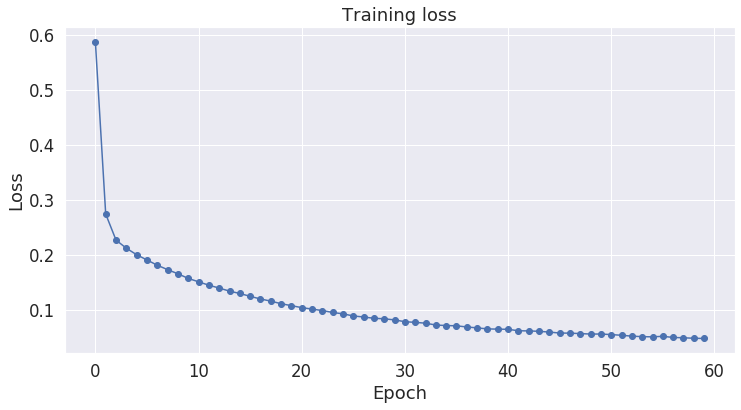

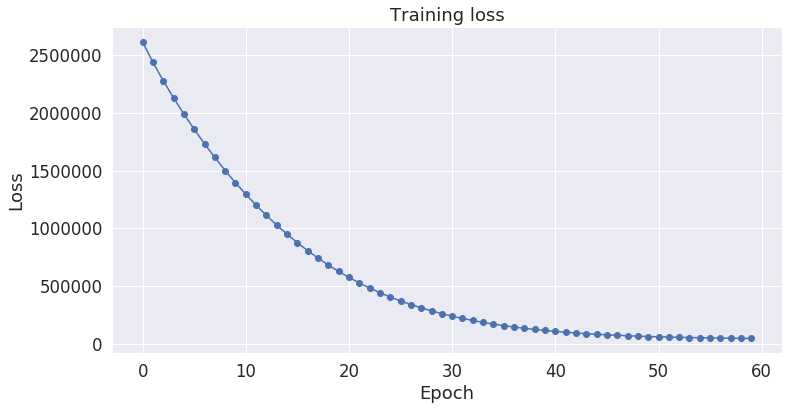

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,micro,macro,weighted,samples
Recall,0.586289,0.447095,0.586289,0.637535
Precision,0.576954,0.525727,0.565313,0.614437
F_Score,0.581584,0.471192,0.566385,0.582441


In [0]:
import random
import numpy as np

'''
hidden_layer_size = random.choice([128,256,512,1024])
batch_size = random.choice([128,256,512])
learning_rate = np.random.uniform(0.01, 0.0001)
dropout = np.random.uniform(0.5, 0.8)
sigmoid_thresh = np.random.uniform(0.3, 0.6)
weight_decay = np.random.uniform(0.1, 0.01)
num_maxout_units = np.random.randint(2,10)
max_norm = np.random.randint(5,20)
'''
epochs = 60
hidden_layer_size = 512
batch_size = 256
learning_rate = 0.001
dropout = 0.7
sigmoid_thresh = 0.5
weight_decay = 0.01
num_maxout_units = 10
max_norm = 10

hyperparameters = {'hidden_layer_size' : hidden_layer_size, 'epochs' : epochs, 'batch_size' : batch_size, 'learning_rate' : learning_rate, 'dropout' : dropout, 'scheduler_step_size' : 99999, 
                    'scheduler_lr_fraction' : 0.85, 'sigmoid_thresh' : sigmoid_thresh, 'num_maxout_units' : num_maxout_units, 'weight_decay' : weight_decay, 'max_norm' : max_norm}
for key, value in hyperparameters.items():
  print(key," : ",value)


train_test = Training_Testing_MM( Data_train_tensor_text, Data_train_tensor_image, Labels_train_tensor, 
                                  Data_test_tensor_text, Data_test_tensor_image, Labels_test_tensor, 
                                  Data_val_tensor_text, Data_val_tensor_image, Labels_val_tensor, Label_names=Label_names, 
                                  hidden_layer_size = hidden_layer_size, epochs = epochs, batch_size= batch_size, learning_rate = learning_rate, dropout = dropout, scheduler_step_size = 99999, 
                                  scheduler_lr_fraction = 0.85, sigmoid_thresh = sigmoid_thresh, num_maxout_units = num_maxout_units, weight_decay = weight_decay, max_norm = max_norm)
train_test.Train()
train_test.Test()

